In [71]:
import geojson
import pandas as pd
import shapely
from matplotlib import pyplot as plt
from matplotlib.path import Path
from pathlib import Path as pathlib
import numpy as np
from scipy.ndimage import distance_transform_edt as dt
from datetime import datetime
from ipi_utils import get_newest_cell_data as gn

In [72]:
def match_polygon(coord_list, pos, in_tumor, image):
    
    coords = np.array(coord_list[0],np.uint32)
    p = Path(coords)
    tf = p.contains_points(pos)
    
    in_tumor[tf] = 1

    image[coords[:,0],coords[:,1]] = 0
    
    if len(coord_list) > 1:
        
        for holes in coord_list[1:]:
            coords = np.array(holes)
            p = Path(coords)
            tf = p.contains_points(pos)
            coords = np.array(coords,np.uint32)
            image[coords[:,0],coords[:,1]] = 0
            in_tumor[tf] = 0
    
    return in_tumor

In [73]:
cell_data_table_dir = pathlib("/media/austin/IPI_8plex/analysis/cell_data_tables/")
um_ppix = 0.325
today = datetime.today().strftime('%Y%m%d')

In [74]:
for sample_dir in cell_data_table_dir.iterdir():

    if not sample_dir.is_dir():
        continue

    sample_name = sample_dir.name
    file_path = gn(sample_dir)

    df = pd.read_csv(file_path)
    df = df[df['DAPI_expressed']==1]

    y = np.array(df['centroid-0'].values, dtype=np.int16)
    x = np.array(df['centroid-1'].values, dtype=np.int16)
    pos = np.vstack((x,y)).transpose()

    #lbl = np.array(["in_tumor_boundary"]*pos.shape[0])
    in_tumor = np.array(np.zeros(pos.shape[0]), dtype=np.int8)
    in_pockets = np.array(np.zeros(pos.shape[0]), dtype=np.int8)
    near_border = np.array(np.zeros(pos.shape[0]), dtype=np.int8)

    with open(pathlib(cell_data_table_dir.parent, "tumor_annotations",sample_name + "_annotations.txt"),"r") as f:
        data = geojson.load(f)

        s = int(np.max([x.max(), y.max()]))

        image = np.ones((s+10000,s+10000))

        for i, obj in enumerate(data):

            if obj['geometry']['type'] == 'Polygon':
                in_tumor = match_polygon(obj['geometry']['coordinates'], pos, in_tumor, image)
            elif obj['geometry']['type'] == 'MultiPolygon':
                for polygon in obj['geometry']['coordinates']:
                    in_tumor = match_polygon(polygon, pos, in_tumor, image)

        # distance transform and then convert to microns
        distance_image = dt(image)*um_ppix
        distances = distance_image[x,y]
        near_border[distances<10] = 1


    df['in_tumor'] = in_tumor
    df['dist_tumor_boundary_um'] = distances
    df['near_border'] = near_border
    
    data.to_csv(Path(sample_dir, f"{sample_name}_single_cell_data_{today}.csv"), index=None)

AttributeError: 'list' object has no attribute 'to_csv'

In [63]:

#df['in_pockets'] = in_pockets

try:
    df = df.drop('Unnamed: 0', axis=1)
    df = df.drop('Unnamed: 0.1', axis=1)
except KeyError:
    pass
#df.to_csv(save_filepath, index=None)

ValueError: Length of values (125856) does not match length of index (56932)

In [42]:
distances.sort()
print(distances)

[  0.           0.           0.         ... 593.14779408 593.16836143
 594.87270592]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


"\nplt.scatter(y,x,c=distances,cmap='Greens')\n\nfor i, obj in enumerate(data):\n    coord_list = obj['geometry']['coordinates']\n        \n    coords = np.array(coord_list[0])\n    p = Path(coords)\n    \n    plt.scatter(p.vertices[:,1], p.vertices[:,0], color=[1,0,0])\n    \n    if len(coord_list) > 1:\n        \n        for holes in coord_list[1:]:\n            coords = np.array(holes)\n            p = Path(coords)\n            plt.scatter(p.vertices[:,1], p.vertices[:,0], color=[1,0,0])\n\n\n\nplt.axis('off')\nplt.show()\n"

<Figure size 1440x1440 with 0 Axes>

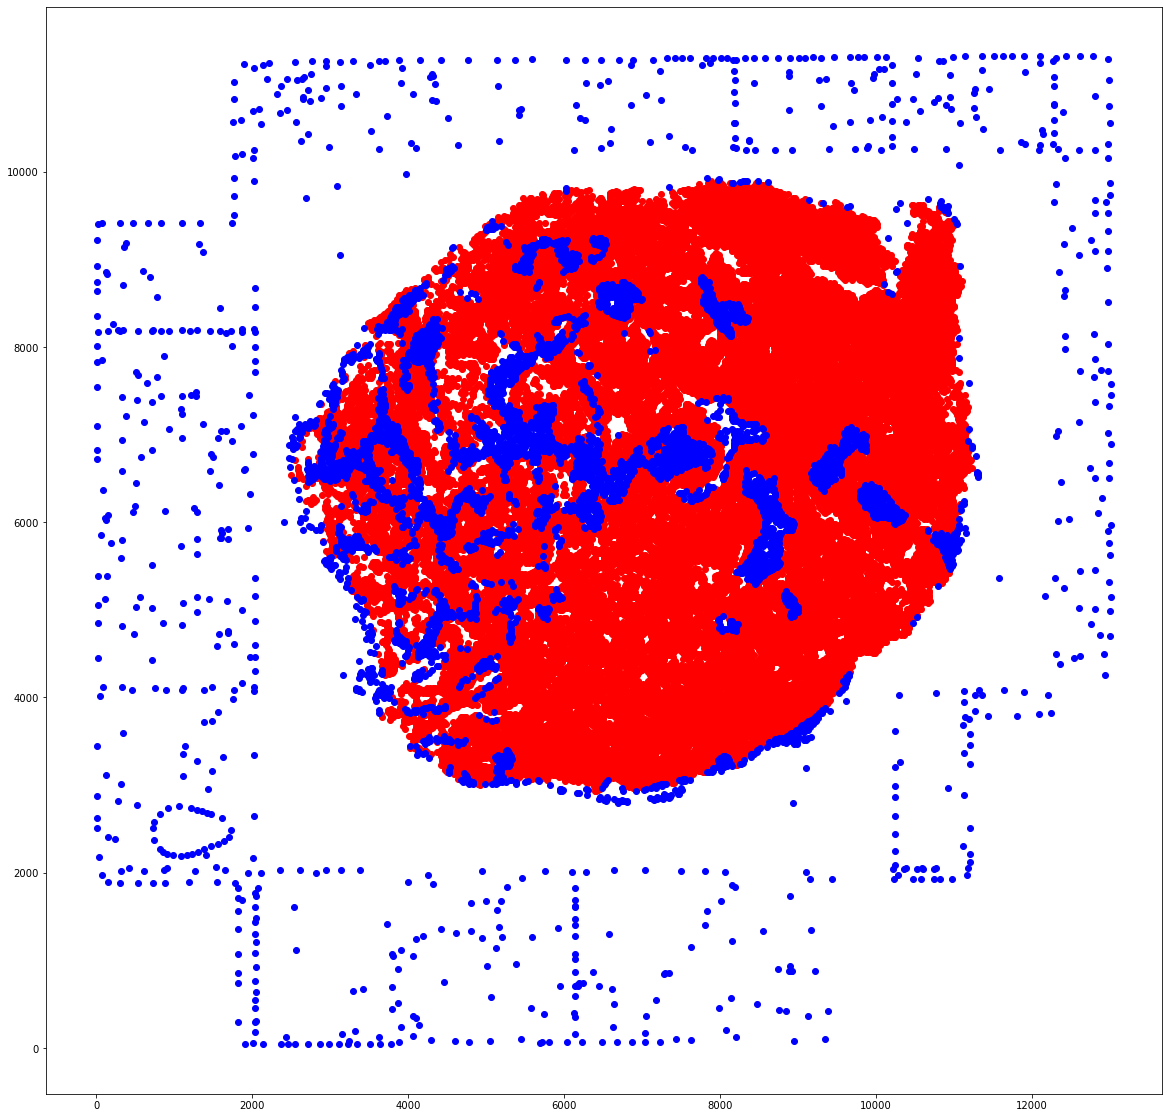

In [66]:
f = plt.figure(figsize=(20,20))

plot = True
if plot: 
    plt.figure(figsize=(20,20))
    #fig, ax = plt.subplots(1)

    
#:
    
tumor = df[df['in_tumor'] == 1] 
stroma = df[df['in_tumor'] ==0 ]

plt.scatter(tumor['centroid-0'],tumor['centroid-1'],c=[1,0,0])
plt.scatter(stroma['centroid-0'],stroma['centroid-1'],c=[0,0,1])

'''
plt.scatter(y,x,c=distances,cmap='Greens')

for i, obj in enumerate(data):
    coord_list = obj['geometry']['coordinates']
        
    coords = np.array(coord_list[0])
    p = Path(coords)
    
    plt.scatter(p.vertices[:,1], p.vertices[:,0], color=[1,0,0])
    
    if len(coord_list) > 1:
        
        for holes in coord_list[1:]:
            coords = np.array(holes)
            p = Path(coords)
            plt.scatter(p.vertices[:,1], p.vertices[:,0], color=[1,0,0])



plt.axis('off')
plt.show()
'''

In [163]:
distances = distance_image[x,y]
df['in_tumor'] = lbl
df['dist_tumor_boundary_um'] = distances

df.to_csv(save_filepath, index=None)

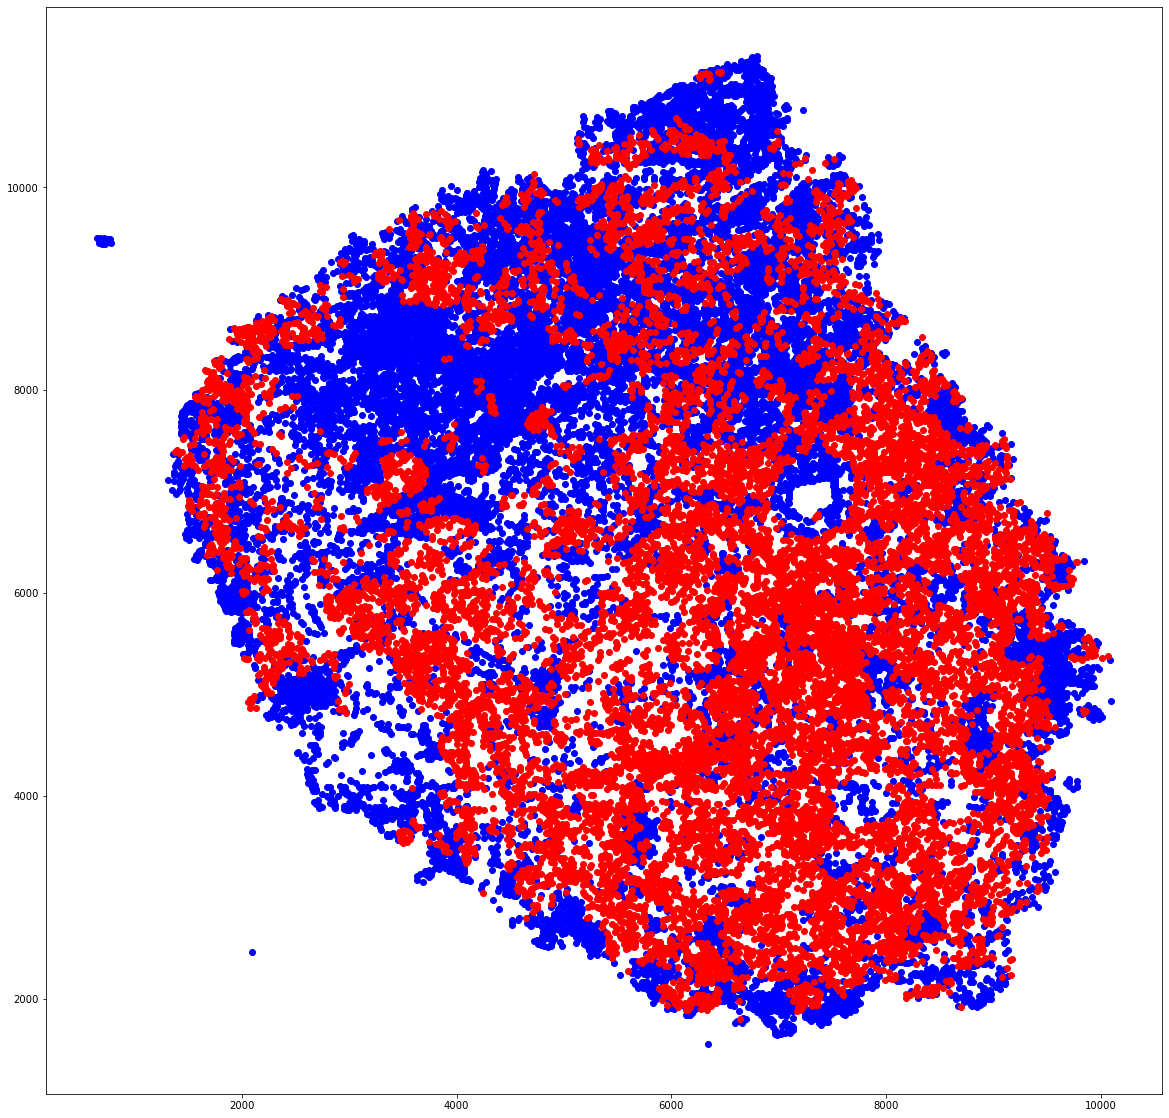